In [ ]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model

###
import warnings
warnings.filterwarnings("ignore")


model_path = ""
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=get_model_name_from_path(model_path)
)


You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


In [2]:
import torch
import torch.nn.functional as F
def compute_js_divergence_between_layers(dict_outputs, layer_indices):
        num_layers = layer_indices

        # Initialize a list to hold JS divergences
        js_divergences = []

        for i in range(num_layers - 1):
            # Indexes for current and next layers
            current_layer = i
            next_layer = i+1

            # 1. Get the output for current and next layers
            output_current_layer = dict_outputs[current_layer].to(torch.float64)  # Convert to float64
            output_next_layer = dict_outputs[next_layer].to(torch.float64)  # Convert to float64

            # 2. Calculate softmax values for current_layer and next_layer
            softmax_current_layer = F.softmax(output_current_layer, dim=-1)
            softmax_next_layer = F.softmax(output_next_layer, dim=-1)

            # 3. Calculate M, the average distribution
            M = 0.5 * (softmax_current_layer + softmax_next_layer)  # shape: (batch_size, num_features)

            # 4. Calculate log-softmax for KL divergence
            log_softmax_current_layer = F.log_softmax(output_current_layer, dim=-1)
            log_softmax_next_layer = F.log_softmax(output_next_layer, dim=-1)

            # 5. Calculate KL divergences and then JS divergence
            kl1 = F.kl_div(log_softmax_current_layer, M, reduction='none').mean(-1)  # shape: (batch_size,)
            kl2 = F.kl_div(log_softmax_next_layer, M, reduction='none').mean(-1)  # shape: (batch_size,)
            js_div = 0.5 * (kl1 + kl2).mean()  # Scalar value for JS divergence

            # Append to the list
            js_divergences.append(js_div.item())

        return js_divergences

In [2]:
image_file = ""
prompt='Please describe this image in detail.'
args = type('Args', (), {
    "model_base": None,
    "model_name": get_model_name_from_path(model_path),
    "query": prompt,
    "conv_mode": None,
    "image_file": image_file,
    "sep": ",",
    "temperature": 0,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 256,
    "model":model,
    "tokenizer":tokenizer,
    "image_processor":image_processor,
    "output_hidden_states": True,
    "return_dict_in_generate": True,
})()

all_output=eval_model(args)
output_text = tokenizer.decode(all_output['sequences'][0], skip_special_tokens=True)
print(output_text)

NameError: name 'get_model_name_from_path' is not defined

In [10]:
with torch.no_grad():
    hidden_states = all_output["hidden_states"]
    output_ids = all_output["sequences"][0]
    all_js = []

    for j, layer_hidden_states in enumerate(hidden_states):
        # 1) Convert each hidden state in the current layer to logits
        word_distribution = [model.lm_head(hs) for hs in layer_hidden_states]
        # Concatenate along dim=0 to form [num_tokens, vocab_size] or a similar shape
        word_distribution = torch.cat(word_distribution, dim=0)

        # 2) For the first layer, select a specific portion
        if j == 0:
            distribution = word_distribution[:, -1, :]  # Example: only the last position
        else:
            distribution = word_distribution

        # 3) Compute the JS divergence across this distribution
        js_distance = compute_js_divergence_between_layers(distribution, len(word_distribution))

        # 4) Convert the (j+1)-th token ID to a string and store {token_str: [list_of_js_values]} in all_js
        token_str = tokenizer.convert_ids_to_tokens(output_ids[j + 1].item())
        all_js.append({token_str: list(js_distance)})



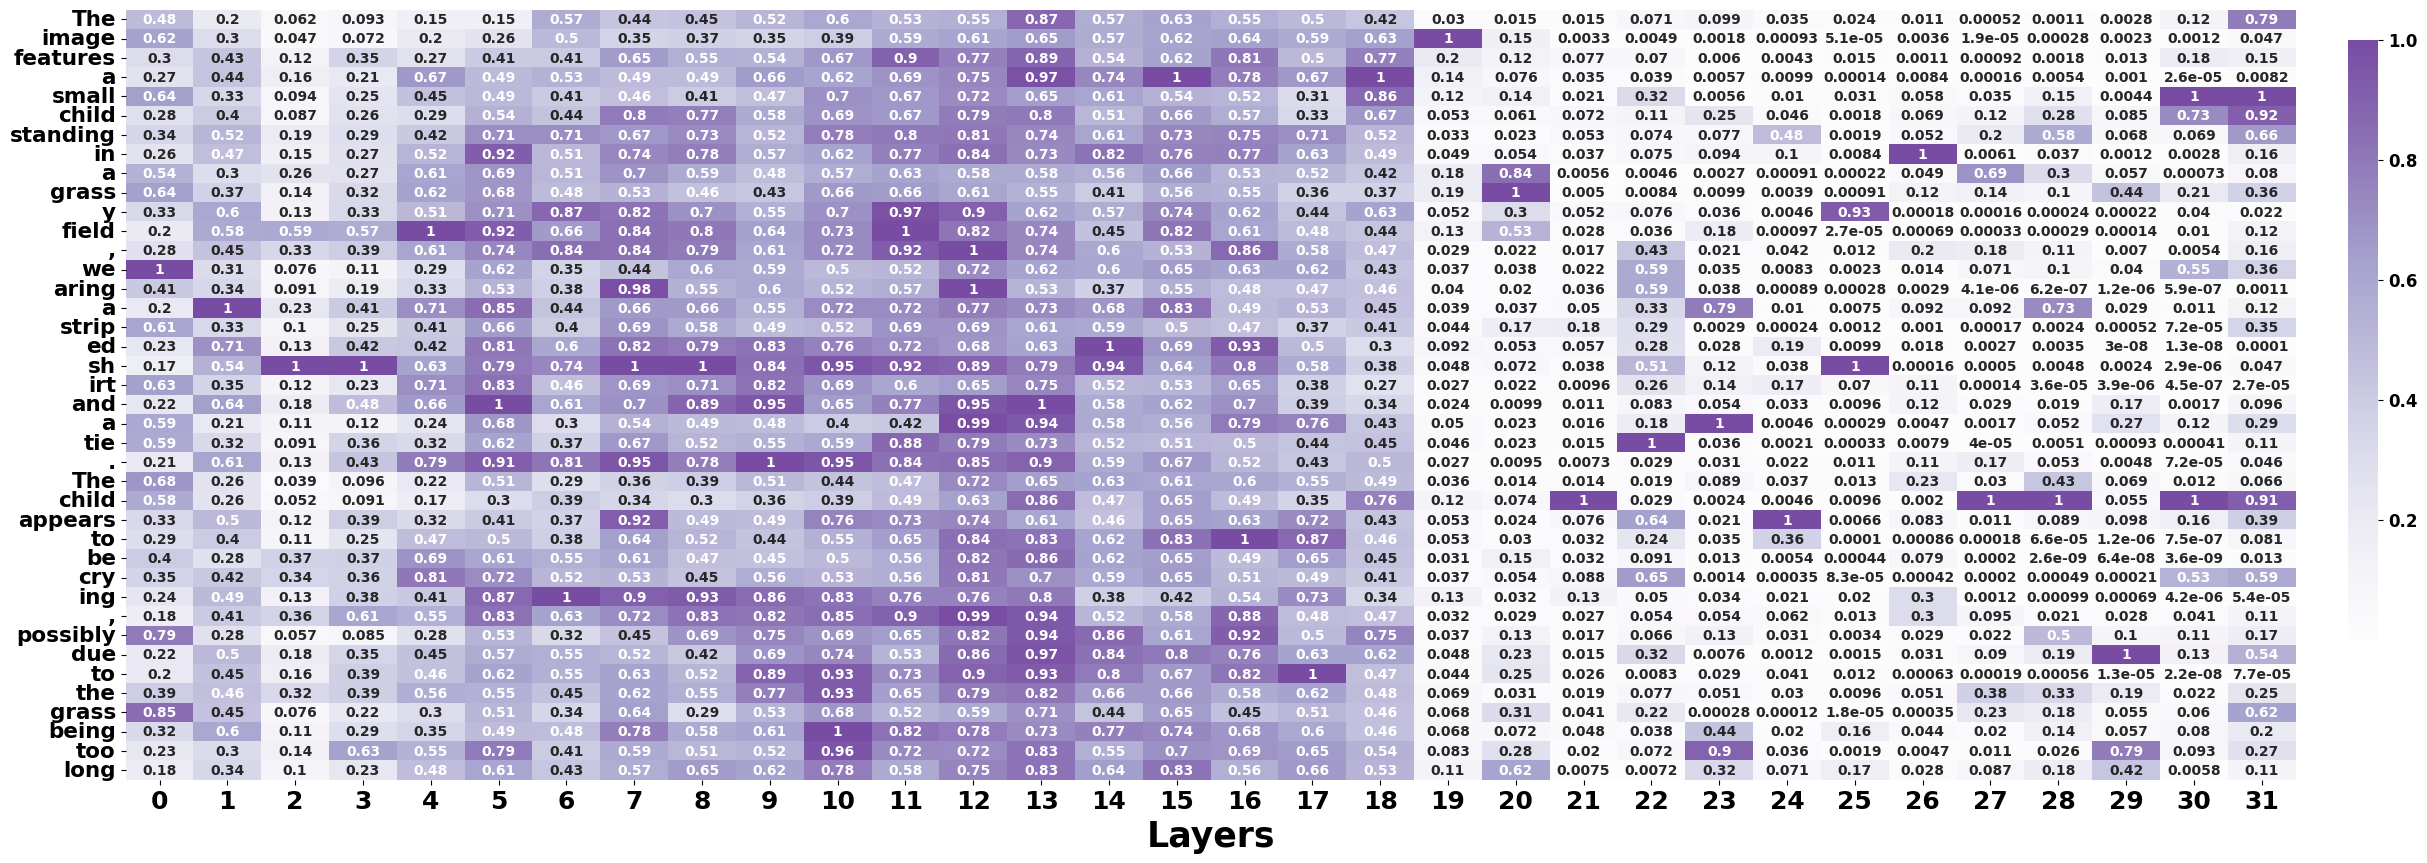

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from sklearn.preprocessing import MaxAbsScaler
plt.rcParams["font.family"] = 'DejaVu Sans'

keys = []
values = []
for data in all_js[:40]:  ##set 40 to enhance images for greater beauty and clarity.
    for key, value in data.items():
        keys.append(key.replace("▁", ""))
        values.append(value)


data_matrix = np.vstack(values)

scaler = MaxAbsScaler()
data_matrix_normalized = scaler.fit_transform(data_matrix)


rotated_matrix = data_matrix_normalized[:, :]

y_labels = list(range(0, len(value), 1))
plt.figure(figsize=(35, 10))  

# tab20
cmap = plt.get_cmap('Purples')
ax = sns.heatmap(
    rotated_matrix, 
    annot=True, 
    cmap=cmap, 
    cbar=True, 
    xticklabels=y_labels, 
    yticklabels=keys,
    annot_kws={"fontsize": 10, "fontweight": "bold"},  
        alpha=0.7
)


ax.set_xlabel("Layers", fontsize=25, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18, fontweight='bold') 
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15.5, fontweight='bold', rotation=0)  
xticklabels = ax.get_xticklabels()


cbar = ax.collections[0].colorbar
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(12)     
    t.set_fontweight('bold') 
cbar.ax.set_position([0.76, 0.25, 0.02, 0.6])

#plt.savefig('./heatmap.png', dpi=600, bbox_inches='tight')
plt.show()
